# Liver Model Construction: Notebook

Trying to get switch between glycolysis and gluconeogenesis without compartments. Copy of 0.0.1-glycolysis_gluco_w_out_comp_split 

started on 1 june 2022

updates:
- tryign to make a function to haave objective fucntion based on glucose conc
0.0.1 --> simulates with standard fluxes


- 0.0.2 sampling fluxes and conc, finding mean values and using that to simulate

- 0.0.3  trying to add glycogen 25 July 22


In [21]:
import os
import re
import warnings
# from cobra.io import 
import cobra
from cobra.io.json import *
import escher
import mass
import numpy as np
import pandas as pd
import equilibrator_api
from equilibrator_api import ComponentContribution, Q_
import sympy as sym
from cobra import Model, Reaction, Metabolite, DictList
import cobra.test
from os.path import join
from mass.util import qcqa,qcqa_model
from mass import (
    MassConfiguration, MassMetabolite, MassModel,
    MassReaction, Simulation, UnitDefinition)
from mass.io.json import save_json_model as save_json_mass_model
from mass.visualization import plot_comparison, plot_time_profile, plot_ensemble_phase_portrait, plot_ensemble_time_profile
mass_config = MassConfiguration()
mass_config.irreversible_Keq = float("inf")
print("MASSpy version: {0}".format(mass.__version__))
from six import iteritems
import matplotlib.pyplot as plt
from mass.thermo import (
    ConcSolver, sample_concentrations,
    update_model_with_concentration_solution)


import cobra_dict as c_d
import csv
import altair as alt
from minspan.minspan import minspan,nnz
from tqdm import tqdm
from scipy.integrate import solve_ivp

MASSpy version: 0.1.6


In [22]:
maps_dir = os.path.abspath("maps")
data_dir = os.path.abspath("data")
ref_dir = os.path.abspath("reference files")
dir = os.path.abspath("")
model_dir = os.path.abspath("models")
minspan_dir= os.path.abspath("minspans_csv")

In [23]:
from mass.io.sbml import read_sbml_model
from mass.io.sbml import validate_sbml_model

In [24]:
# liver_holz = os.path.join(ref_dir,"liver.sbml")
# model, errors = validate_sbml_model(liver_holz)

In [25]:
# liver_holz = os.path.join(ref_dir,"liver.sbml")

# liver_mass, errors = read_sbml_model(liver_holz)

### Getting reactions and metabolite data from RECON 3D

In [26]:
# making dataframe of metabolites

csv_met = os.path.join(data_dir,"gly_gluco_glycogen_no_compts_met_df.csv")
met_csv_df = pd.read_csv(csv_met,index_col="id")
metabolite_info=met_csv_df.to_dict(orient='index')

# making dataframe of reactions
# csv_rxn = os.path.join(data_dir,"gly_gluco_reaction_df.csv")
# rxn_csv_df = pd.read_csv(csv_rxn,index_col="id") 
# reaction_info = rxn_csv_df.to_dict(orient='index')

### Loading cobra model

In [27]:
# Initiate empty model
trial= cobra.Model()

In [28]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in metabolite_info.items():
    met = cobra.Metabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], 
                        #    compartment=info['compartment']
                           )
    trial.add_metabolites(met)

rxn_json = os.path.join(data_dir,"gly_gluco_glycogen_no_compt_reaction_df.json")
with open(rxn_json) as json_file:
    rxn_data = json.load(json_file)

    
for reaction, info in rxn_data.items():
    reaction_obj = cobra.Reaction(reaction)
    reaction_obj.id=reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    trial.add_reaction(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    print(reaction)

HEX1
PGI
FBP
PFK
FBA
TPI
GAPD
PGK
PGM
ENO
PEPCKm
PYK
PCm
LDH_L
PGMT
GLPASE2
GLDBRAN
GLBRAN
GLPASE1
GLGNS1
GGNG
GALUi
ADK1
ATPM


In [29]:
#adding NADHM 
nadhm = {'nadh': -1, 'h': 1, 'nad': 1}
rxn = cobra.Reaction('NADHM')
trial.add_reaction(rxn)
rxn.add_metabolites(nadhm)




# gly_syn = {'glygn2': -1, 'g1p': 1}
# rxn2 = cobra.Reaction('PEPtm')
# trial.add_reaction(rxn2)
# rxn2.add_metabolites(peptm)



g6pase = {'g6p': -1, 'h2o': -1, 'pi': 1, 'glc__D':1}
rxn3 = cobra.Reaction('G6PP')
trial.add_reaction(rxn3)
rxn3.add_metabolites(g6pase)
trial.reactions.G6PP.lower_bound=0

trial.metabolites.h.charge= 1
# trial.metabolites.h.charge= 1
# trial.metabolites.h_e.charge= 1
trial.metabolites.pi.charge= -2
# trial.metabolites.pi_m.charge= -2

In [30]:
# μmol substrate /gww.hep/min
# https://link.springer.com/article/10.1007/s10439-006-9217-2/tables/2 

# trial.reactions.G6PP.lower_bound = 0
trial.reactions.LDH_L.upper_bound = 195

trial.reactions.PEPCKm.upper_bound = 5.66 

In [47]:
#Mass balance check
for r in trial.reactions:
    print(r.id,  r.check_mass_balance())

HEX1 {}
PGI {}
FBP {}
PFK {}
FBA {}
TPI {}
GAPD {}
PGK {}
PGM {}
ENO {}
PEPCKm {}
PYK {}
PCm {}
LDH_L {}
PGMT {}
GLPASE2 {}
GLDBRAN {}
GLBRAN {}
GLPASE1 {}
GLGNS1 {}
GGNG {}
GALUi {}
ADK1 {}
ATPM {}
NADHM {'charge': 2}
G6PP {}
EX_glc__D {'C': -6, 'H': -12, 'O': -6}
EX_h2o {'H': -2, 'O': -1}
EX_h {'charge': -1, 'H': -1}
EX_pi {'charge': 2, 'H': -1, 'O': -4, 'P': -1}
EX_lac__L {'charge': 1, 'C': -3, 'H': -5, 'O': -3}
EX_pyr {'charge': 1, 'C': -3, 'H': -3, 'O': -3}
EX_co2 {'C': -1, 'O': -2}
EX_hco3 {'charge': 1, 'C': -1, 'H': -1, 'O': -3}
EX_gtp {'charge': 4, 'C': -10, 'H': -12, 'N': -5, 'O': -14, 'P': -3}
EX_amp {'charge': 2, 'C': -10, 'H': -12, 'N': -5, 'O': -7, 'P': -1}
EX_gdp {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -11, 'P': -2}
EX_adp {'charge': 3, 'C': -10, 'H': -12, 'N': -5, 'O': -10, 'P': -2}
EX_glygn2 {'C': -66, 'H': -111, 'O': -56, 'X': -1}
EX_udp {'charge': 3, 'C': -9, 'H': -11, 'N': -2, 'O': -12, 'P': -2}
EX_utp {'charge': 4, 'C': -9, 'H': -11, 'N': -2, 'O': -15, 'P': 

In [31]:
for met in ['glc__D', 
'h2o', 
'h', 
'pi',
'lac__L',    
'pyr',
# 'o2',
'co2',
'hco3', 'gtp',
'amp','gdp','adp',
# 'g1p',
'glygn2',
    # 'atp',
     'udp',
    'utp','ppi',
    'Tyr_ggn',
    # 'glygn3', 

     ]:
    rxn = cobra.Reaction('EX_%s' % met)
    name = rxn.id
    
    if name not in trial.reactions:
        print(rxn.id)
        trial.add_reaction(rxn)
        rxn.add_metabolites({met: -1})
        rxn.lower_bound = -1000
        if met == 'glc__D':
            rxn.lower_bound = -0.585 # by convention negative exchange flux = uptake
            rxn.upper_bound = 57 # μmol substrate /gww.hep/min
            # https://link.springer.com/article/10.1007/s10439-006-9217-2/tables/2 
        elif met == 'amp':
            rxn.upper_bound = 1

        elif met == 'lac__L':
            
            rxn.upper_bound = 3.24 # μmol substrate /gww.hep/min
            # https://link.springer.com/article/10.1007/s10439-006-9217-2/tables/2 
        # elif met == 'atp':
        # try chaining upper bound glucose to 100 and see
        #     rxn.upper_bound = 0
        elif met == 'pyr':
            
            rxn.upper_bound = 0 # μmol substrate /gww.hep/min
        #     # https://link.springer.com/article/10.1007/s10439-006-9217-2/tables/2 
        
        elif met == 'glygn2':
            
            rxn.upper_bound = 0.304 #μmole C6/gww/min
            rxn.lower_bound = 0 #μmole C6/gww/min
        #     # https://link.springer.com/article/10.1007/s10439-006-9217-2/tables/2       
        
        # elif met == 'g1p':
            
        #     rxn.lower_bound = 0 

        else:
            rxn.upper_bound = 1000


            # keep the split between fed anf fasting state

EX_glc__D
EX_h2o
EX_h
EX_pi
EX_lac__L
EX_pyr
EX_co2
EX_hco3
EX_gtp
EX_amp
EX_gdp
EX_adp
EX_glygn2
EX_udp
EX_utp
EX_ppi
EX_Tyr_ggn


In [32]:
from cobra.io import json
import cobra.test

In [33]:
# #Escher FBA: shows the solutions on the map
# initial_flux_data = {
#     reaction: flux
#     for reaction, flux in flux_solution.fluxes.items()}


#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_Glycogen.json"
        )
        ,highlight_missing=True
    # , reaction_data=initial_flux_data
    )

# Display map in notebook
escher_builder

Builder(highlight_missing=True)

In [34]:
trial.metabolites.glygn2

Metabolite identifier,glygn2
Name,"Glycogen, structure 2..."
Memory address,0x023826959130
Formula,C66H111O56X
Compartment,None
In 3 reaction(s),"EX_glygn2, GLBRAN, GLPASE1"


In [35]:
futile_cycle_1 = trial.problem.Constraint(
    trial.reactions.PFK.flux_expression - trial.reactions.FBP.flux_expression,
    lb=-10,
    ub=10)
trial.add_cons_vars(futile_cycle_1)


futile_cycle_2 = trial.problem.Constraint(
    trial.reactions.HEX1.flux_expression - trial.reactions.G6PP.flux_expression,
    lb=-10,
    ub=10)
trial.add_cons_vars(futile_cycle_2)


futile_cycle_3 = trial.problem.Constraint(
    trial.reactions.PYK.flux_expression - trial.reactions.PCm.flux_expression,
    lb=-10,
    ub=10)
trial.add_cons_vars(futile_cycle_3)

# . It generally is accepted that in an overnight, post-absorptive state,
#  the contribution of glycogenolysis and gluconeogenesis to overall glucose production is approximately equal.
# https://onlinelibrary.wiley.com/doi/10.1002/dmrr.863

In [68]:
trial.objective = "EX_glc__D"
flux_solution = trial.optimize()
flux_solution

,fluxes,reduced_costs
HEX1,0.00,-0.5
PGI,-0.25,-0.0
FBP,0.25,0.0
PFK,0.00,-0.5
FBA,-0.25,-0.0
...,...,...
EX_glygn2,0.00,-22.0
EX_udp,0.00,-0.0
EX_utp,0.00,-0.0
EX_ppi,0.00,-0.0


In [76]:
with trial:
    trial.objective = {trial.reactions.EX_glc__D: 0.5,
    trial.reactions.EX_glygn2: 0.5 }
    trial.optimize()
    print(trial.reactions.EX_glygn2.flux)

0.0


In [74]:
from cobra.util.solver import linear_reaction_coefficients

In [75]:
linear_reaction_coefficients(trial)


{<Reaction EX_glc__D at 0x23826922af0>: 1.0}

In [42]:
# #Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}


#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_Glycogen.json"
        )
        # ,highlight_missing=True
    , reaction_data=initial_flux_data
    )

# Display map in notebook
escher_builder

Builder(reaction_data={'HEX1': 0.0, 'PGI': -0.25, 'FBP': 0.25, 'PFK': 0.0, 'FBA': -0.25, 'TPI': -0.25, 'GAPD':…

In [43]:
gly_gluco_json = os.path.join(model_dir,"glycolysis_gluconeogenesis_glycogen_no_cmpt.json")
json.save_json_model(model=trial, filename=gly_gluco_json)

In [48]:
# np.linspace?
# for 
switch = pd.DataFrame(columns=["Gluc_conc", "Objective_val"])
range = np.linspace(2,14,num=240)
list_objs=[]
for i in range:
    
    if i >7.5:
        trial.objective = 'ATPM'
        flux_solution = trial.optimize()
        obj_val = flux_solution.objective_value
    else:
        trial.objective = "EX_glc__D"
        flux_solution = trial.optimize()
        obj_val = flux_solution.objective_value
    list_objs.append(obj_val)
   
switch["Gluc_conc"] = range
switch["Objective_val"] = list_objs
switch= switch.set_index("Gluc_conc")

        

In [49]:
from matplotlib import pyplot as plt

<AxesSubplot:>

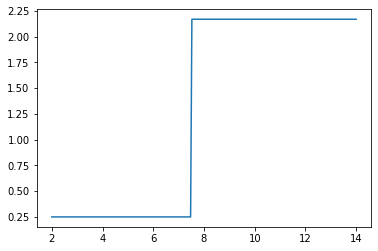

In [50]:
fig, ax = plt.subplots(1,1)
plt.plot(switch["Objective_val"])
ax

## Solution Space (sampling)

In [ ]:
# combined =trial.copy()
# combined.objective= "ATPM"
# flux_solution = combined.optimize()
# df_gly = cobra.sampling.sample(combined,  5000, method = "optgp", processes = 4)

# fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# ax = axes[0]
# df_gly['PFK'].hist(ax=ax)
# ax.set_xlabel('PFK flux')
# ax.set_ylabel('Number of solutions')

# ax = axes[1]
# ax = df_gly['FBP'].hist(ax=ax)
# ax.set_xlabel('FBP flux')

In [ ]:
# # df
# mean_flux = pd.DataFrame( columns =["reaction","mean", "stdev"])
# # means =[]
# # std=[]
# for i in df_gly.columns:
#     mean = df_gly[i].mean()
#     # print(index)
#     # means.append(index)
#     std = df_gly[i].std()
#     mean_flux.loc[len(mean_flux.index)] = [i, mean, std]
# # mean_flux["Mean_gluco"] = means
# # mean_flux["ST_dev_gluco"] = std
# mean_flux

Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmp6m_pgt2u.lp
Reading time = 0.00 seconds
: 39 rows, 89 columns, 257 nonzeros
Read LP format model from file C:\Users\sicil\AppData\Local\Temp\tmpv80cxe_k.lp
Reading time = 0.00 seconds
: 40 rows, 89 columns, 259 nonzeros


Text(0.5, 0, 'G6PP flux')

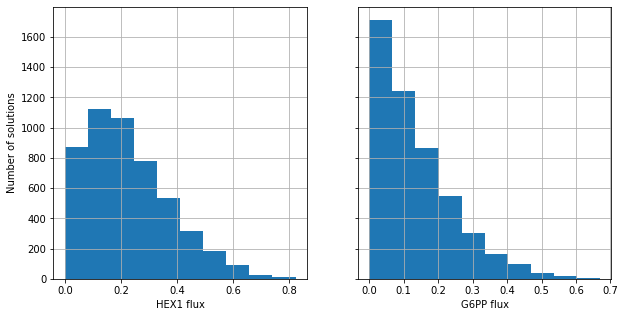

In [83]:
combined =trial.copy()
combined.objective= "EX_glc__D"
flux_solution = combined.optimize()
co = combined.problem.Constraint(combined.reactions.EX_glc__D.flux_expression, lb=0)
combined.add_cons_vars([co])


df = cobra.sampling.sample(combined, 5000, method = "optgp", processes = 4)

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['HEX1'].hist(ax=ax)
ax.set_xlabel('HEX1 flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['G6PP'].hist(ax=ax)
ax.set_xlabel('G6PP flux')

Text(0.5, 0, 'FBP flux')

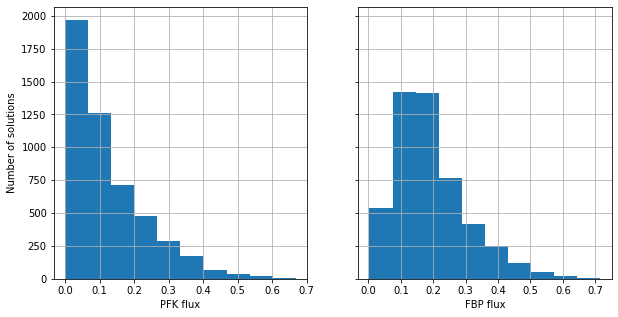

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax = axes[0]
df['PFK'].hist(ax=ax)
ax.set_xlabel('PFK flux')
ax.set_ylabel('Number of solutions')

ax = axes[1]
ax = df['FBP'].hist(ax=ax)
ax.set_xlabel('FBP flux')

In [85]:
# df
mean_flux = pd.DataFrame( columns =["reaction","mean", "stdev"])
# means =[]
# std=[]
for i in df.columns:
    mean = df[i].mean()
    # print(index)
    # means.append(index)
    std = df[i].std()
    mean_flux.loc[len(mean_flux.index)] = [i, mean, std]
# mean_flux["Mean_gluco"] = means
# mean_flux["ST_dev_gluco"] = std
mean_flux

,reaction,mean,stdev
0,HEX1,0.227172,0.148780
1,PGI,-0.068277,0.038864
2,FBP,0.192327,0.109960
3,PFK,0.124050,0.111601
4,FBA,-0.068277,0.038864
5,TPI,-0.068277,0.038864
6,GAPD,-0.136554,0.077728
7,PGK,0.136554,0.077728
8,PGM,0.136554,0.077728
9,ENO,-0.136554,0.077728


In [86]:
mean_flux_csv=os.path.join(
    data_dir,"mean_fluxes.csv"
    )
mean_flux.to_csv(mean_flux_csv)

In [87]:
#  sample fluxes, conc, get percs, then try pushing
# optgp
# when running samples make sure cobrapy- check sampling, sample, check method


# dFBA analysis

In [88]:
def add_dynamic_bounds(trial, y):
    """Use external concentrations to bound the uptake flux of glucose."""
    atpm, glucose = y  # expand the boundary species
    glucose_max_import = -10 * glucose / (5 + glucose)
    trial.reactions.EX_glc__D.lower_bound = glucose_max_import


def dynamic_system(t, y):
    """Calculate the time derivative of external species."""

    atpm, glucose = y  # expand the boundary species

    # Calculate the specific exchanges fluxes at the given external concentrations.
    with trial:
        add_dynamic_bounds(trial, y)

        cobra.util.add_lp_feasibility(trial)
        feasibility = cobra.util.fix_objective_as_constraint(trial)
        lex_constraints = cobra.util.add_lexicographic_constraints(
            trial, ['EX_glygn2', 'EX_glc__D'], ['max', 'max'])
# try max and mim 
    # Since the calculated fluxes are specific rates, we multiply them by the
    # biomass concentration to get the bulk exchange rates.
    fluxes = lex_constraints.values
    # fluxes *= atpm

    # This implementation is **not** efficient, so I display the current
    # simulation time using a progress bar.
    if dynamic_system.pbar is not None:
        dynamic_system.pbar.update(1)
        dynamic_system.pbar.set_description('t = {:.3f}'.format(t))

    return fluxes

dynamic_system.pbar = None


def infeasible_event(t, y):
    """
    Determine solution feasibility.

    Avoiding infeasible solutions is handled by solve_ivp's built-in event detection.
    This function re-solves the LP to determine whether or not the solution is feasible
    (and if not, how far it is from feasibility). When the sign of this function changes
    from -epsilon to positive, we know the solution is no longer feasible.

    """

    with trial:

        add_dynamic_bounds(trial, y)

        cobra.util.add_lp_feasibility(trial)
        feasibility = cobra.util.fix_objective_as_constraint(trial)

    return feasibility - infeasible_event.epsilon

infeasible_event.epsilon = 1E-6
infeasible_event.direction = 1
infeasible_event.terminal = True

In [89]:
ts = np.linspace(0, 15, 100)  # Desired integration resolution and interval
y0 = [0.1, 10]

with tqdm() as pbar:
    dynamic_system.pbar = pbar

    sol = solve_ivp(
        fun=dynamic_system,
        events=[infeasible_event],
        t_span=(ts.min(), ts.max()),
        y0=y0,
        t_eval=ts,
        rtol=1e-6,
        atol=1e-8,
        method='BDF'
    )

t = 1.313: : 52it [00:04, 14.60it/s]Exception ignored in: <function tqdm.__del__ at 0x0000023825006D30>
Traceback (most recent call last):
  File "c:\Users\sicil\miniconda3\envs\massliver\lib\site-packages\tqdm\std.py", line 1147, in __del__
    self.close()
KeyboardInterrupt: 
t = 3.136: : 159it [00:17, 10.16it/s]

Text(0, 0.5, 'Glucose')

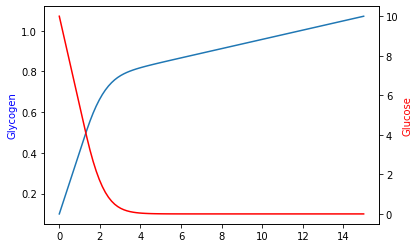

In [ ]:
ax = plt.subplot(111)
ax.plot(sol.t, sol.y.T[:, 0])
ax2 = plt.twinx(ax)
ax2.plot(sol.t, sol.y.T[:, 1], color='r')

ax.set_ylabel('Glycogen', color='b')
ax2.set_ylabel('Glucose', color='r')

## FVA analysis

In [ ]:
def plot_fva(atpm_values, max_pfk_values, max_fbp_values, min_pfk_values, min_fbp_values):
    """
    Parameters
    ----------
    atpm_values : list
        list of ATPM flux values from 0 to max
        
    max_g6pdh_values : list
        list of maximum G6PDH2r flux values at the ATPM fluxes in atpm_values
    max_pgi_values : list
        list of maximum PGI flux values at the ATPM fluxes in atpm_values

    min_g6pdh_values : list 
        list of minimum G6PDH2r flux values at the ATPM fluxes in atpm_values

    min_pgi_values : list
        list of minimum PGI flux values at the ATPM fluxes in atpm_values

    """
    plt.fill_between(atpm_values, max_pfk_values, min_pfk_values, 
                     label='Glycolysis', alpha=.7)
    plt.fill_between(atpm_values, max_fbp_values, min_fbp_values, 
                     label='Gluconeogenesis', alpha=.7)
    plt.legend()
    plt.xlabel('ATPM flux')
    plt.ylabel('Range of possible fluxes')

In [1]:
combined = trial.copy()
rxn = 'ATPM'
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

NameError: name 'trial' is not defined

In [ ]:
combined = trial.copy()
rxn = "EX_glc__D"
var_rxn = 'PFK'
var_rxn_2 = 'FBP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [ ]:
combined = trial.copy()
rxn = "ATPM"
var_rxn = 'HEX1'
var_rxn_2 = 'G6PP'
combined.objective = rxn
obj = combined.optimize().objective_value
print(obj)
bounds = np.linspace(0, obj, 10)
lower = []
upper = []
lower_2 = []
upper_2 = []
for bound in bounds:
    combined.reactions.get_by_id(rxn).upper_bound = bound
    combined.reactions.get_by_id(rxn).lower_bound = bound


    combined.objective = var_rxn
    lower.append(combined.optimize('minimize').objective_value)
    upper.append(combined.optimize().objective_value)
    combined.objective = var_rxn_2
    upper_2.append(combined.optimize('minimize').objective_value)
    lower_2.append(combined.optimize().objective_value)
    
    combined.reactions.get_by_id(rxn).lower_bound = 0


plot_fva(bounds, upper, upper_2, lower, lower_2)

In [ ]:
# trial.problem.Constraint

In [ ]:
# Try dfba

In [ ]:
# same_flux = trial.problem.Constraint(
#     trial.reactions.PFK.flux_expression - trial.reactions.FBP.flux_expression,
#     lb=0,
#     ub=1)
# trial.add_cons_vars(same_flux)

In [ ]:
# flux_solution = trial.optimize()
# flux_solution

In [ ]:
# solution = trial.optimize()
# print(solution.fluxes['FBP'], solution.fluxes['PFK'],
#       solution.objective_value)



In [ ]:
from cobra.flux_analysis import flux_variability_analysis

In [ ]:
trial.optimize()
trial.summary(fva=0.95)

In [ ]:
flux_variability_analysis(trial, trial.reactions)

In [ ]:
#Escher FBA: shows the solutions on the map
initial_flux_data = {
    reaction: flux
    for reaction, flux in flux_solution.fluxes.items()}


#view all the reactions that we need build
escher_builder = escher.Builder(
    model=trial,
    map_json=os.path.join(
        maps_dir,"Glycolysis_Gluconeogenesis_2.json")
    , reaction_data=initial_flux_data)

# Display map in notebook
escher_builder

In [ ]:
# trial.objective = 'ATPM'
# fba_solution = trial.optimize()
# pfba_solution = cobra.flux_analysis.pfba(trial)
# pfba_solution


In [ ]:
# geometric_fba_sol = cobra.flux_analysis.geometric_fba(trial)
# geometric_fba_sol

In [ ]:

from cobra.sampling import sample

# model = load_model("textbook")
s = sample(trial, 100)
# s.head()
s


In [ ]:

from cobra.io import json
import cobra.test
import os
from os.path import join
from glob import glob

In [ ]:
gly_gluco_json = os.path.join(model_dir,"glycolysis_gluconeogenesis_no_cmpt.json")
json.save_json_model(model=trial, filename=gly_gluco_json)

In [ ]:
# import cplex 
# import gurobipy 

In [ ]:
# for model_file in glob(gly_gluco_json):
#     model_name = model_file.split('/')[-1]
#     if 'model' not in model_name:
#         continue
#     print(model_name)
#     model= load_json_model(model_file)
#     if 'NADPHM' in model.reactions:
#         model.remove_reactions(['NADPHM'])
#     # media = ['EX_lac__L_c', 'EX_pyr_c', 'EX_octa_c', 'EX_gln__L_c', 'EX_acetone_c', 'EX_bhb_c',
#     #          'EX_glu__L_c', 'EX_ser__L_c', 'EX_cys__L_c', 'EX_gly_c', 'EX_ala__L_c', 'EX_so3_c',
#     #         'EX_etoh_c', 'EX_fru_c']
#     media = ['EX_glc__D_c']
#     for met in media:
#         if met in model.reactions:
#             model.reactions.get_by_id(met).lower_bound = -1000.

#     rxns = [i.id for i in model.reactions]
#     # removed blocke reactions because it included ['PEPCKm', 'PCm', 'PYRt2m', 'ADK1', 'PEPtm', 'EX_h2o_c', 'EX_pi_c']
#     # blocked = cobra.flux_analysis.find_blocked_reactions(model)
#     # print(blocked)
#     # model.remove_reactions(blocked)

#     solved_fluxes = minspan(model, cores=3, verbose=False, timelimit=60)
    
#     df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in model.reactions])
#     df = df/df.abs().max()
#     for col in range(len(df.columns)):
#         column=df.iloc[:,col]
#         vals = column.values
#         min_val = min([abs(i) for i in vals if i != 0])
#         corr_fac=1/min_val
#         # print(corr_fac)
#         vals=vals*abs(corr_fac)
#         df['Norm'+ str(col)]=vals
#     csv_dir = os.path.join(minspan_dir,"gly_gluco_csv.csv")
#     df.to_csv(csv_dir)
#     # csv_minspan_dir = os.path.join(minspan_dir,"liver_csv_minspan.csv")
# ## WHere it's stored
# csv_minspan_dir = os.path.join(minspan_dir,"gly_gluco_csv.csv")

In [ ]:
# solved_fluxes = minspan(gluco, cores=3, verbose=False, timelimit=60)

# df = pd.DataFrame(solved_fluxes.copy(), index=[i.id for i in gluco.reactions])
# df = df/df.abs().max()
# for col in range(len(df.columns)):
#     column=df.iloc[:,col]
#     vals = column.values
#     min_val = min([abs(i) for i in vals if i != 0])
#     corr_fac=1/min_val
#     # print(corr_fac)
#     vals=vals*abs(corr_fac)
#     df['Norm'+ str(col)]=vals
# csv_dir = os.path.join(minspan_dir,"gluco_csv.csv")
# df.to_csv(csv_dir)

In [ ]:
# making dataframe 
# df = pd.read_csv(csv_minspan_dir,index_col=0) 
# df

In [ ]:
import escher
from escher import Builder

In [ ]:
# initial_minspan_data = {
#     reaction: flux
#     for reaction, flux in df.iloc[:,18].iteritems()}

In [ ]:
# #view all the reactions that we need build
# escher_builder = escher.Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"Glycolysis_Gluconeogenesis.json")
#     , reaction_data=initial_flux_data)


# New instance to prevent modifications to the existing maps
# escher_builder = Builder(
#     model=trial,
#     map_json=os.path.join(
#         maps_dir,"Glycolysis_Gluconeogenesis_2.json"),
#     reaction_data=initial_minspan_data)

# # Display map in notebook
# escher_builder

In [ ]:
# from cobra.io import json

In [ ]:
# core_json = os.path.join(model_dir,"Glycolysis_Gluconeogenesis.json")
# json.save_json_model(model=trial, filename=core_json)

In [ ]:
trial.objective = "EX_glc__D"
flux_solution = trial.optimize()
flux_solution.fluxes

### Making Df of metabolites and reactions, exporting them, and importing to form MASS model

In [ ]:
from cobra_dict import metabolite_to_dict as metabolite_to_dict
from cobra_dict import reaction_to_dict as reaction_to_dict

In [ ]:
met_df=pd.DataFrame()
for met in trial.metabolites:
    cobra_met= trial.metabolites.get_by_id(met.id)
    m=metabolite_to_dict(cobra_met)
    df_2=pd.DataFrame.from_dict(m,orient='index')
    df_2=df_2.T
    met_df=pd.concat([met_df, df_2])
met_df=met_df.set_index('id')
met_df

In [ ]:
csv_met_cobra = os.path.join(data_dir,"gly_gluco_no_cmpt_cobra_met.csv")
met_df.to_csv(csv_met_cobra)

In [ ]:
rxn_df=pd.DataFrame()
for rxn in trial.reactions:
    cobra_rxn= trial.reactions.get_by_id(rxn.id)
    r=reaction_to_dict(cobra_rxn)
#     print(r)
    df=pd.DataFrame.from_dict(r,orient='index')
    df=df.T
    rxn_df= pd.concat([rxn_df, df])
rxn_df=rxn_df.set_index('id')
# rxn_df

In [ ]:
json_rxn_cobra = os.path.join(data_dir,"gly_gluco_no_cmpt_cobra_rxn.json")
rxn_df.to_json(json_rxn_cobra,orient="index")

## Making MASS model of glycolysis

In [ ]:
liver= MassModel("Core_Model", array_type='DataFrame', dtype=np.int64)

#### Add the pathway metabolites and their information to a new MASS model from COBRA model

In [ ]:
# making dataframe of metabolites
import json
met_csv_df = pd.read_csv(csv_met_cobra,index_col="id")
mass_metabolite_info=met_csv_df.to_dict(orient='index')

# Loading reaction data as JSON file to maintain data types as dictionaries 

with open(json_rxn_cobra) as json_file:
    mass_rxn_data = json.load(json_file)

In [ ]:
#  Add all the remaining metabolites involved in the pathway
for met_id, info in mass_metabolite_info.items():
    met = MassMetabolite(met_id, name=info['name'], formula=info['formula'], 
                           charge=info['charge'], compartment=info['compartment'])
    liver.add_metabolites(met)

In [ ]:
for reaction, info in mass_rxn_data.items():
    reaction_obj = MassReaction(reaction)
    reaction_obj.id = reaction
    reaction= reaction_obj.id
    reaction_obj.lower_bound = info['lower_bound']
    reaction_obj.upper_bound = info['upper_bound']
    reaction_obj.name = info['name']
    liver.add_reactions(reaction_obj)
    temp=info['metabolites']
    reaction_obj.add_metabolites(temp)
    # print(reaction)

In [ ]:
liver.reactions.PGK.reverse_stoichiometry(inplace=True)
liver.reactions.PGM.reverse_stoichiometry(inplace=True)

## Setting initial conditions

In [ ]:
import csv
import openpyxl

In [ ]:
#Function to load data from the excel sheet
def load_data(filepath, sheet_name):
    """Load Liver data from an excel sheet"""
    df = pd.read_excel(engine='openpyxl',
        io=filepath,
        sheet_name=sheet_name,
        index_col=0)
    return df

In [ ]:
#Compare Results
excel_ic = os.path.join(data_dir,"Concentrations3_no_cmpt.xlsx")
# ic_df = pd.read_csv(csv_ic)
# ic_df.set_index()
ic_info_all = load_data(
    filepath=excel_ic,
    sheet_name="Concentrations")
ic_info_all.reset_index(level='ID', col_level=1, inplace=True)
ic_info_all

In [ ]:
conc_df =pd.DataFrame(ic_info_all.loc[:,["ID","Concentration (M)"]])
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

In [ ]:
new_index= []
for i in conc_df.index:
    base = conc_df.index.get_loc(i)
    # print(base)
    l = len(i)
    new = i[:l-2]
    new_index.append(new)
    # print(new)
    # conc_df.index.get_loc(base) = new
    # new_id = i.rpartition("_" + str(met.compartment))[0]

conc_df= conc_df.reset_index(drop=True)
conc_df["ID"] = new_index
conc_df.set_index('ID',drop=True,inplace=True)
conc_df

In [ ]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in conc_df.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = conc_df.loc[mid,'Concentration (M)']
            row = [mid,ic_value]
            # column = [ic_value]
            # conc_df.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

In [ ]:
# ic_info

### Getting Standard and Physiological Gibbs energies of reactions to get Keq of reactions

In [ ]:
met_list = []
liver.boundary_conditions
for reaction in liver.boundary_conditions:
    print(reaction)

In [ ]:
# for reaction in liver.boundary:
#     excluded_reactions.append(reaction.id)
#     reaction.Keq=1    # Setting Keq
#     print(reaction,reaction.Keq)

In [ ]:
for i in liver.metabolites:
    i.compartment = "cytosol"

In [ ]:
# Reactions that we don't want to get Keq from equilibrator [exchanges and psuedoreactions] SET THESE MANUALLY
# Setting Keq and kf for boundary reactions
print("Boundary Reactions and Values\n-----------------------------")
excluded_reactions=["ATPM", "NADHM","PYRt2m","PEPtm"]

for reaction in liver.boundary:
    excluded_reactions.append(reaction.id)
    reaction.Keq=1    # Setting Keq
    reaction.kf=1e6     # Setting kf
    #Setting boundary condition metabolties from ic of metabolite from HEPATOKIN   
    for met in reaction.reactants:
        if met.id in conc_df.index:
            mid=met.id
            boundary_met = reaction.boundary_metabolite
            bcvalue = conc_df.loc[mid,'Concentration (M)']
            liver.boundary_conditions[boundary_met] =  bcvalue
            bc_value = liver.boundary_conditions.get(boundary_met)
            print("{0}\n{1}: {2}\n".format(reaction, boundary_met, bc_value))

In [ ]:
reaction_str= []
cc = ComponentContribution()
# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.31)
cc.ionic_strength = Q_("0.144M")
cc.temperature = Q_("310.15K")
R = 0.00831446261815324 #R = 0.00831446261815324 kJ/mol
from numpy import *
Keq_df=pd.DataFrame(columns=["Reaction","Keq"])
# Keq_df

In [ ]:
# Getting Keq from equilibrator by forming a reaction string that it can parse through
for reaction in liver.reactions:
    if reaction.id not in excluded_reactions:
        reactants = []
        #forming reaction string 
        for met in reaction.reactants:
            id_coeff= reaction.get_coefficient(met)
            new_id = met.id
            # new_id = met.id.rpartition("_" + str(met.compartment))[0] #removing compartment lettes, for eg "_c"
            if id_coeff == 1 or id_coeff == -1:
                new_id = "bigg.metabolite:" + new_id
            else:
                new_id = str(id_coeff) + " bigg.metabolite:" + new_id

            reactants.append(new_id)   
        reactants_string= " + ".join(reactants)
        reactants_string = str(reactants_string + " = ")

        # Forming product string
        products = []
        for met in reaction.products:
            new_id = met.id
            # new_id = met.id.rpartition("_" + str(met.compartment))[0] # removing compartment lettes, for eg "_c"
            new_id = "bigg.metabolite:" + new_id
            products.append(new_id)   
        products_string= " + ".join(products)

        #final reaction to parse
        reaction_to_parse = reactants_string + products_string         
        # print(reaction_to_parse)
        rxn_parsed = cc.parse_reaction_formula(reaction_to_parse)
        print(reaction.id)

        #Getting Gibbs energies
        dG0_prime = cc.standard_dg_prime(rxn_parsed)
    #         print(f"ΔG'° = {dG0_prime}")
        dGm_prime = cc.physiological_dg_prime(rxn_parsed)
        dG_prime_value_in_kj_per_mol = dGm_prime.value.m_as("kJ/mol")
        dG0prime_value_in_kj_per_mol = dG0_prime.value.m_as("kJ/mol")
    #     print(f"ΔG'm = {dG_prime_value_in_kj_per_mol}")
        delG = dG_prime_value_in_kj_per_mol

        # Calculating Keq from delG
        a = exp(-delG/ (R*310.15)) 
        reaction.Keq = a
        print(f"Keq = {a}")
#         list_keq=[reaction,a]
#         rxn_keq=pd.DataFrame(list_keq)
        # df = pd.DataFrame([[reaction,a]], columns=["Reaction","Keq"])
        # Keq_df.append(df)

# Keq_df    

In [ ]:
liver.reactions.NADHM.Keq=1e6
liver.reactions.ATPM.Keq=1e6
# liver.reactions.PEPtm.Keq=1
# liver.reactions.PYRt2m.Keq=1

In [ ]:
print("Equilibrium Constants\n---------------------")
for reaction in liver.reactions:
    print("{0}: {1}".format(reaction.Keq_str, reaction.Keq))

##  Set Fluxes

In [ ]:
flux_solution

In [ ]:
flux_solution

In [ ]:
reaction_list=[]
for reaction in liver.reactions:
    reaction_list.append(reaction.id)


In [ ]:
mean_flux

In [ ]:
# mean_flux = mean_flux.T
fluxes_mean = mean_flux.drop(["ST_dev"], axis =1)
# fluxes_mean
fluxes_mean.columns = [''] * len(fluxes_mean.columns)
fluxes_mean

In [ ]:
for reaction, flux in fluxes_mean.itertuples():
    # print(flux)
    reaction = liver.reactions.get_by_id(reaction)
    reaction.steady_state_flux = flux * 1278.605 / 1000 # mmol/gdW*hr --> mmol/L * hr ---> mol/L*hr
    print("{0}: {1}".format(reaction.flux_symbol_str,
                            reaction.steady_state_flux))

## Set H2O/H Constants

In [ ]:
# Set concentrations of hydrogen, water as fixed
# Assume hydrogen in all compartments are fixed 
for metabolite in [
    "h",
#     'h_e',
# 'h_m',
#     'h2o_r','h2o_e',
    "h2o",
#     "glc__D_e", "pi_e",
# 'pi_m',
    'pi'
                  ]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.fixed = True

In [ ]:
for metabolite in [
    'h',
# "h_c", 
#     'h_e',
"h2o",
#     'h2o_r','h2o_e' 
]:
    metabolite = liver.metabolites.get_by_id(metabolite)
    metabolite.ic = 1 #M

In [ ]:
seed = int(4)
n_models = 5000

In [ ]:
conc_solver.setup_sampling_problem(
    fixed_conc_bounds=list(liver.fixed),
    fixed_Keq_bounds=liver.reactions.list_attr("Keq_str"))
for variable in conc_solver.variables:
    try:
        met = liver.metabolites.get_by_id(variable.name)
        variable.lb, variable.ub = np.log([met.ic / 10, met.ic * 10])
    except:
        pass
conc_samples = sample_concentrations(conc_solver, n=n_models,  processes=4, seed=seed)
conc_samples.head()


In [ ]:
type(conc_samples)

In [ ]:
mean_conc = pd.DataFrame(index = conc_samples.columns)
means =[]
std=[]
for i in conc_samples.columns:
    index = conc_samples[i].mean()
    # print(index)
    means.append(index)
    std.append(conc_samples[i].std())
mean_conc["Mean"] = means
mean_conc["ST_dev"] = std
mean_conc

In [ ]:
print("Initial Conditions\n------------------")

for reaction in liver.reactions:
    #Setting inital condition of metabolties from HEPATOKIN  #M 
    for met in reaction.metabolites:
        if met.id in mean_conc.index:
            mid=met.id
            metabolite = reaction.metabolites
            ic_value = mean_conc.loc[mid,'Mean']
            row = [mid,ic_value]
            # column = [ic_value]
            # conc_df.append(row)
            met.ic =  ic_value            
for metabolite, ic_value in liver.initial_conditions.items():
    print("{0}: {1}".format(metabolite, ic_value))

In [ ]:
# Keq_data = pd.read_csv("./data/analysis_data/equilibrium_constants.csv", index_col=0)

# Keq_data_comparison_fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
# plot_comparison(
#     x=Keq_data["Initial"], y=Keq_data["Adjusted"], ax=ax,
#     title="Equilibrium Constants comparison",
#     legend="right outside", plot_function="loglog",
#     xlim=(1e-5, 1e5), ylim=(1e-5, 1e5), 
#     xy_line=True,
#     xy_legend="best", xlabel="Initial", ylabel="Adjusted")

# Keq_data_comparison_fig.tight_layout()

In [ ]:
Boundary= [
    "ATPM",
    
#     'EX_nad_c',
    # "EX_lac__L_c"
]
for x in Boundary:
    a=liver.reactions.get_by_id(x)
    a.kf=1e6

In [ ]:
#Formulate QP minimization list for concentrations
conc_solver = ConcSolver(
    liver, 
    excluded_metabolites=[
    "h",'h2o',
    
#         'h_e',
#  'h_m',
#     'h2o_r','h2o_e',
        'pi',
    # 'pi_c',
#     "pi_e",
"glc__D",
#     "glc__D_e", "lac__L_e",
#     "pyr_e"
    ], 
    excluded_reactions=[
        # "Ht", "H2Ot", "H2Oter",'PIter','PIt',
#     'G6Pter','GLCter','GLCt1',
'PYRt2m','PEPtm',
'NADHM','ATPM',
'CO2tm', 'ATPtm', 'Htm','PIt2m'
    # 'L_LACt2r','PYRt2'
    ],

    constraint_buffer=1)

conc_solver.setup_feasible_qp_problem(
fixed_conc_bounds=list(liver.fixed))
# fixed_Keq_bounds=liver.reactions.list_attr("Keq_str")
    
#assumption: provide uncertainity to allow for a variance for the Keqs rather than staying fixed
#conc_solver.setup_feasible_qp_problem(Keq_percent_deviation=0.1)

conc_solution = conc_solver.optimize()
conc_solution

In [ ]:
conc_comparison_fig, ax = plt.subplots(nrows=1, ncols=1,
                                       figsize=(5, 5))

plot_comparison(
    x=conc_df["Concentration (M)"], y=conc_solution,
    compare="concentrations",
    observable=[mid for mid in conc_df.index], ax=ax,
    legend="right outside", plot_function="loglog", 
    xlim=(1e-6,0.02), ylim=(1e-6,1e-1),
    xy_line=True,
    xy_legend="best", xlabel="Initial [mol/L]", ylabel="Adjusted [mol/L]")

conc_comparison_fig.tight_layout()
update_model_with_concentration_solution(
    liver, conc_solution, concentrations=True, inplace=True)

In [ ]:
liver.calculate_PERCs(fluxes={
                r: v for r, v in liver.steady_state_fluxes.items()
                if not (r.boundary  
                       )
}, update_reactions=True)
# print(percs)                      

print("Forward Rate Constants\n----------------------")
for reaction in liver.reactions:
    print("{0}: {1:.6f}".format(reaction.kf_str, reaction.kf))

In [ ]:
#Function to add underscore in front of metabolite identifiers which start with a number
## fix this only after getting Keq from equlibrator because bigg doesn't have _13dpg for example
def prefix_number_id(id_str):
    """Prefix identifiers that start with numbers."""
    if re.match(r"^\d", id_str):
        id_str = "_" + id_str
    return id_str

In [ ]:
#Loop to edit the names using "prefix_number_id" function defined earlier
for metabolite in liver.metabolites:
    new_met_id = prefix_number_id(metabolite.id)
    metabolite.id = new_met_id
liver.repair()

In [ ]:
qcqa_model(liver, parameters=True, concentrations=True,
           fluxes=True, superfluous=True, elemental=True)

In [ ]:
conc_solution.concentrations

In [ ]:
liver.boundary_conditions['co2_b']=0.657953 ##M
liver.boundary_conditions['gdp_b']=0.657953 ##M
liver.boundary_conditions['gtp_b']=1.519864 ##M
liver.boundary_conditions['h2o_b']=1 ##M
liver.boundary_conditions['h_b']=1 ##M
liver.boundary_conditions['hco3_b']=0.001827 ##M

In [ ]:
# Setup simulation object
simG=Simulation(liver, verbose=True)
# Simulate from 0 to 1000 with 10001 points in the output
conc_sol, flux_sol = simG.simulate(liver, time=(0, 1e8))
# Quickly render and display time profiles
conc_sol.view_time_profile()

In [ ]:
# Loading reaction data as JSON file to maintain data types as dictionaries 
model_json = os.path.join(model_dir,"Gly_Gluco_no_cmpt.json")
json.save_json_model(mass_model=liver, filename=model_json)

In [ ]:
#function to set x label and y label
def set_x_label(xlabel):
    if xlabel==None:
        xlabel="Time"
    else:
        xlabel=xlabel
    return xlabel
        
def set_y_label(ylabel):        
    if ylabel==None:
        ylabel="Concentrations"
    else:
        ylabel=ylabel
    return ylabel


In [ ]:
#function to make plot typelinear log
def set_plot_type(plot_type):
    if plot_type == None:
        x_plot_type = 'log'
        y_plot_type = 'log'
    elif plot_type == "logx":
        x_plot_type = 'log'
        y_plot_type = 'linear'
    elif plot_type == "logy":
        x_plot_type = 'linear'
        y_plot_type = 'log'
    elif plot_type == "linear":
        x_plot_type = 'linear'
        y_plot_type = 'linear'
    elif plot_type == "logxlogy":
        x_plot_type = 'log'
        y_plot_type = 'log'
    return x_plot_type,y_plot_type


In [ ]:
def view_all_conc_sol(conc_sol,
#                       dynamic=True
                      xlim=None,ylim=None,plot_type=None,xlabel=None,ylabel=None,width=None,height=None):
    """Generate an interactable time profile which can zoom into the plot with interactive tooltip"""
    #Shift click to click multiple
    
    data=conc_sol.to_frame()
    data = data.reset_index().melt('Time', var_name='Metabolites', value_name='Concentrations')
    
    # Setting X limit and Y limit
    def set_ylim(ylim):
        if ylim == None:
            conc=data['Concentrations']
            ylim_max=max(conc)
            ylim=[1e-5,ylim_max]
        else:
            ylim=ylim
        return ylim
    
    def set_xlim(xlim):
        if xlim == None:
            xlim_max=data['Time'].iloc[-1]
            xlim=[1e-5,xlim_max]

        else:
            xlim=xlim
        return xlim
    xlim=set_xlim(xlim)
    ylim=set_ylim(ylim)
        
       
    # Setting type of plot
    x_plot_type=set_plot_type(plot_type)[0]
    y_plot_type=set_plot_type(plot_type)[1]
        
    # Setting x label and y label
    xlabel=set_x_label(xlabel)
    ylabel=set_y_label(ylabel)
    # Setting width and height
    if width==None:
        width=500
    else:
        width=width
        
    if height==None:
        height=300
    else:
        height=height
    
    alt.data_transformers.disable_max_rows()
    selection = alt.selection_multi(fields=['Metabolites'])
    color = alt.condition(selection,
                          alt.Color('Metabolites:N', legend=None),
                          alt.value('lightgray'))

    line = alt.Chart(data).mark_line(clip=True).encode(alt.X('Time:Q',
                                                             title=xlabel,
                                                             scale=alt.Scale(type = x_plot_type,
                                                                             padding = 10,
                                                                             domain = xlim,
#                   zero=True,
                              ),
              axis=alt.Axis(tickCount=5)),
        alt.Y('Concentrations:Q',
              title=ylabel,
              scale=alt.Scale(type=y_plot_type,
                              padding = 10,
                              domain = ylim,
#                   zero=True, 
                             ),
               axis=alt.Axis(grid=False,
                             tickCount=5)),
        color=color,
        tooltip= ["Metabolites"]+["Time"]+["Concentrations"]
    ).properties(width=width, height=height).interactive()

    
    
#         if dynamic == False:
#             A = alt.layer(line)
#         else:
    legend = alt.Chart(data).mark_point().encode(
        y=alt.Y('Metabolites:N', axis=alt.Axis(orient='right')),
        color=color
    ).add_selection(
        selection
    )
    A= line | legend
    return A

In [ ]:
view_all_conc_sol(conc_sol,plot_type='logxlogy')